# Recurrence Analysis

In [3]:
using CABLAB
using MultivariateAnomalies
using RecurrenceAnalysis
import Patchwork
Patchwork.load_js_runtime()

Path to cube

In [4]:
c=Cube("/home/jovyan/work/datacube/cablab-datacube-0.2.3/low-res/")

CABLAB data cube at /home/jovyan/work/datacube/cablab-datacube-0.2.3/low-res/
Spatial resolution:  1440x720 at 0.25 degrees.
Temporal resolution: 2001-01-01T00:00:00 to 2012-01-01T00:00:00 at 8daily time steps
Variables:           aerosol_optical_thickness_1610 aerosol_optical_thickness_550 aerosol_optical_thickness_555 aerosol_optical_thickness_659 aerosol_optical_thickness_865 air_temperature_2m bare_soil_evaporation black_sky_albedo burnt_area c_emissions country_mask evaporation evaporative_stress fractional_snow_cover gross_primary_productivity interception_loss land_surface_temperature latent_energy net_ecosystem_exchange open_water_evaporation ozone potential_evaporation precipitation root_moisture sensible_heat snow_sublimation snow_water_equivalent soil_moisture surface_moisture terrestrial_ecosystem_respiration transpiration water_mask water_vapour white_sky_albedo 


In [5]:
variables = ["transpiration", "gross_primary_productivity", "latent_energy", "sensible_heat"]
variables2 = ["air_temperature_2m", "precipitation"]
cdata = getCubeData(c,variable=c.dataset_files,longitude=(-10,45),latitude=(35,65),variable=variables)
cdata2 = getCubeData(c,variable=c.dataset_files,longitude=(-10,45),latitude=(35,65),variable=variables2)
#cdata_orig=getCubeData(c,variable=c.dataset_files,variable=variables);

In [6]:
VAR = 7
MAX_CACHE = 1.0e9

1.0e9

In [7]:
sp=sampleLandPoints(cdata,2000)
sp2=sampleLandPoints(cdata2,2000)

In-Memory data cube with the following dimensions
Spatial points axis with 2000 points
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Variable            Axis with elements: air_temperature_2m precipitation 


In [8]:
quant1 = mapCube(timespacequantiles,sp,[0.2,0.8,0.5])
quant2 = mapCube(timespacequantiles,sp2,[0.2,0.8,0.5])

In-Memory data cube with the following dimensions
Quantile            Axis with elements: 0.2 0.8 0.5 
Variable            Axis with elements: air_temperature_2m precipitation 


In [9]:
@everywhere function scaleCubeQuantiles(xout::AbstractVector,xin::AbstractVector,quantiles)
    absm=(abs(quantiles[1]-quantiles[3])+abs(quantiles[2]-quantiles[3]))/2
    for i in eachindex(xin)
        xout[i]=(xin[i]-quantiles[3])/absm # x - median(x) / (mean(abs(quant))
    end
end

In [10]:
# register scaleCubeQuantiles for Time and MSCAxis
registerDATFunction(scaleCubeQuantiles,
((TimeAxis,),(CategoricalAxis{Float64,:Quantile},)),
                   (TimeAxis,),
                   inmissing  = (:nan,:nan),
                   outmissing = :nan,
                   no_ocean   = 1)
# register Version of mwVAR
registerDATFunction(mw_VAR!,(TimeAxis,VariableAxis),(TimeAxis,VariableAxis),inmissing=(:nan,),outmissing=:nan,no_ocean=1)

CABLAB.DAT.DATFunction(((CABLAB.Cubes.Axes.RangeAxis{DateTime,:Time,CABLAB.Cubes.Axes.YearStepRange},CABLAB.Cubes.Axes.CategoricalAxis{String,:Variable}),),((CABLAB.Cubes.Axes.RangeAxis{DateTime,:Time,CABLAB.Cubes.Axes.YearStepRange},CABLAB.Cubes.Axes.CategoricalAxis{String,:Variable}),),(),(Any,),(:nan,),(:nan,),1,true,(zero,),(identity,),("auto",))

In [11]:
# gap fill cube
@time cdata = mapCube(gapFillMSC, cdata, max_cache=MAX_CACHE);
@time cdata2 = mapCube(gapFillMSC, cdata2, max_cache=MAX_CACHE);

 24.787334 seconds (221.00 M allocations: 5.239 GB, 9.63% gc time)


In [12]:
cdata_norm_atmo = mapCube(scaleCubeQuantiles,(cdata,quant1))
cdata_norm_bios = mapCube(scaleCubeQuantiles,(cdata2,quant2))

Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Lon                 Axis with 220 Elements from -10.0 to 44.75
Lat                 Axis with 120 Elements from 65.0 to 35.25
Variable            Axis with elements: air_temperature_2m precipitation 


In [13]:
addprocs(10)

10-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

- local variables

In [14]:
@everywhere using CABLAB
@everywhere using MultivariateAnomalies
@everywhere using RecurrenceAnalysis

In [15]:
@everywhere function getRecurrenceMetrics!(xout, xin, Dtmp, DeltaT = 12, DIM = 3, RR = 0.05)
    if(!any(isnan(xin)))
        x = (xin .- mean(xin, 1)) ./ std(xin, 1)
        embedded = TDE(x, DeltaT, DIM)
        dist_matrix!(Dtmp, embedded)
        eps = quantile(unsafe_wrap(Array, pointer(Dtmp[1]), length(Dtmp[1])), RR)
        rmat = sparse(Dtmp[1] .<= eps)
        xout[1] = determinism(rmat)
        xout[2] = entropy(rmat)
        xout[3] = trend(rmat)[1]
        xout[4] = laminarity(rmat)
        xout[5] = trappingtime(rmat)
    else 
        xout[1] = NaN; xout[2] = NaN; xout[3] = NaN; xout[4] = NaN;
    end
    return(xout)
end

In [16]:
@everywhere inAxes = ((TimeAxis, VariableAxis),)
@everywhere outAxes = (CategoricalAxis("RecurrenceMetrics",["Determinism", "Entropy", "Trend", "Laminarity", "TrappingTime"]), )

In [17]:
@everywhere VAR = 7
@everywhere DIM = 3
@everywhere DeltaT = 12
@everywhere Dtmp = init_dist_matrix(TDE(randn(506, VAR), DeltaT, DIM))

In [18]:
registerDATFunction(getRecurrenceMetrics!,inAxes,outAxes,inmissing=(:nan,:nan),outmissing=:nan,no_ocean=1)

CABLAB.DAT.DATFunction(((CABLAB.Cubes.Axes.RangeAxis{DateTime,:Time,CABLAB.Cubes.Axes.YearStepRange},CABLAB.Cubes.Axes.CategoricalAxis{String,:Variable}),),((RecurrenceMetrics   Axis with elements: Determinism Entropy Trend Laminarity TrappingTime ,),),(),(Any,),(:nan,:nan),(:nan,),1,true,(zero,),(identity,),("auto",))

In [19]:
@time RecMetCube_atmo = mapCube(getRecurrenceMetrics!, cdata_norm_atmo, Dtmp, DeltaT, DIM, max_cache = MAX_CACHE)
@time RecMetCube_bios = mapCube(getRecurrenceMetrics!, cdata_norm_bios, Dtmp, DeltaT, DIM, max_cache = MAX_CACHE)

280.020924 seconds (4.92 M allocations: 199.283 MB, 0.05% gc time)
279.594778 seconds (34.14 k allocations: 1.640 MB)


In [20]:
rmprocs(workers())

:ok

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=1),"",1,"Determinism",Interact.OptionDict(DataStructures.OrderedDict("Determinism"=>1,"Entropy"=>2,"Trend"=>3,"Laminarity"=>4,"TrappingTime"=>5),Dict(4=>"Laminarity",2=>"Entropy",3=>"Trend",5=>"TrappingTime",1=>"Determinism")),Any[],Any[],true,"horizontal")

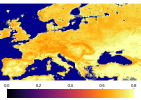

In [25]:
plotMAP(RecMetCube_atmo, dmin=0,dmax=0.8) # Biosphere

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=1),"",1,"Determinism",Interact.OptionDict(DataStructures.OrderedDict("Determinism"=>1,"Entropy"=>2,"Trend"=>3,"Laminarity"=>4,"TrappingTime"=>5),Dict(4=>"Laminarity",2=>"Entropy",3=>"Trend",5=>"TrappingTime",1=>"Determinism")),Any[],Any[],true,"horizontal")

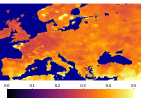

In [22]:
plotMAP(RecMetCube_bios, dmin=0,dmax=0.5) # Atmosphere